# Приоритизация гипотез и анализ A/B-теста

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from functools import reduce
import datetime as dt

##  Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Загрузим данные из исходного файла и изучим его.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Аномалий в данных не обнаружено. Посчитаем показатели ICE и RICE для приоритизации гипотез на основе данных из таблицы.
Будем использовать следующие формулы для расчёта показателей:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [3]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

In [4]:
pd.options.display.max_colwidth = 999
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
hypothesis[{'Hypothesis', 'ICE', 'RICE'}].sort_values(by='RICE', ascending=False)\
.style.apply(highlight_max, props='color:red;', axis=0, subset=['ICE', 'RICE'])

,RICE,ICE,Hypothesis
7,112,11.2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
2,56,7,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
0,40,13.3333,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
6,40,8,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
8,16.2,16.2,"Запустить акцию, дающую скидку на товар в день рождения"
3,9,1.125,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
1,4,2,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,4,1.33333,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
4,3,1,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


### Вывод

На данном этапе были:
- изучены данные из файла;
- с помощью фреймворка ICE и RICE была сделана приоритизация гипотез;
- наиболее перспективные гипотезы по ICE: 8, 0, 7;
- наиболее перспективные гипотезы по RICE: 7, 2, 0;
- после применения фреймворка RICE изменилась приоритизация и гипотеза 7 заняла первое место. Это объясняется тем, что наибольшее влияние оказал параметр Reach, который самый высокий у гипотезы 7. Этот параметр говорит о том, что изменение затронет наибольшее количество пользователей при применении данного гипотезы.

##  Анализ A/B-теста.

### Изучение данных из файлов и предобработка данных

Загрузим данные из файлов orders и visitors и изучим их.

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Структура orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [6]:
display(orders.sample(10, random_state=1))

,transactionId,visitorId,date,revenue,group
886,51443164,4278982564,2019-08-05,24744,A
1093,3894437543,276558944,2019-08-12,5050,A
801,504373597,2604012846,2019-08-05,890,B
189,4189935502,1648269707,2019-08-17,290,B
808,2344401705,366673373,2019-08-05,1460,A
480,1954636284,2600415354,2019-08-06,1530,B
202,532398042,1306302251,2019-08-23,1498,A
311,3567356314,3077396270,2019-08-24,4195,B
866,707525727,1270030113,2019-08-30,3290,B
752,237002862,1398592185,2019-08-20,390,A


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.isnull().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [9]:
orders.duplicated().sum()

0

Пропусков и дубликатов нет, но нужно изменить тип данных в столбце с датами со строки на дату.

In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим корректность распределения пользователей по группам - нет ли пользователей, которые попали в обе группы.
Найдём всех пользователей, которые попали в группу A и в группу B.

In [11]:
visitorsA = orders[orders['group']=='A']['visitorId']
visitorsB = orders[orders['group']=='B']['visitorId']

In [12]:
visitorsA

2       4069496402
7         78758296
8        295230930
10       879864040
12      3213223594
           ...    
1187     132143192
1188    1022829655
1193     370388673
1194     573423106
1195    1614305549
Name: visitorId, Length: 557, dtype: int64

In [13]:
visitorsB

0       3312258926
1       3642806036
3       1196621759
4       2322279887
5        935554773
           ...    
1189     393266494
1190    1197745035
1191     608641596
1192    3733762160
1196    2108080724
Name: visitorId, Length: 640, dtype: int64

Найдём пересечение по пользователям.

In [14]:
visitors_AB = orders.loc[orders['visitorId'].isin(visitorsA)& orders['visitorId'].isin(visitorsB),'visitorId'].unique()
len(visitors_AB)

58

58 пользователей оказались в двух группах одновременно. Удалим таких пользователей, т.к. они могут некорректно повлиять на результаты теста.

In [15]:
orders = orders.loc[~orders['visitorId'].isin(visitors_AB)]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Были удалены заказы пользователей, которые попали в две группы. Поэтому количество строк в таблице уменьшилось до 1016 (а было 1197). Это достаточно большое уменьшение, но зато результаты теста будут более корректны.

Структура visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

In [16]:
display(visitors.sample(10, random_state=1))

,date,group,visitors
21,2019-08-22,A,609
52,2019-08-22,B,650
38,2019-08-08,B,654
24,2019-08-25,A,621
2,2019-08-03,A,507
41,2019-08-11,B,721
60,2019-08-30,B,490
50,2019-08-20,B,560
35,2019-08-05,B,707
44,2019-08-14,B,746


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

In [19]:
visitors.duplicated().sum()

0

Пропусков и дубликатов нет, но нужно изменить тип данных в столбце с датами со строки на дату.

In [20]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Анализ кумулятивных метрик

Чтобы исключить проблему подсматривания, проанализируем графики метрик. 
Сначала посчитаем кумулятивную выручку.

In [21]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим график кумулятивной выручки по дням и по группам.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


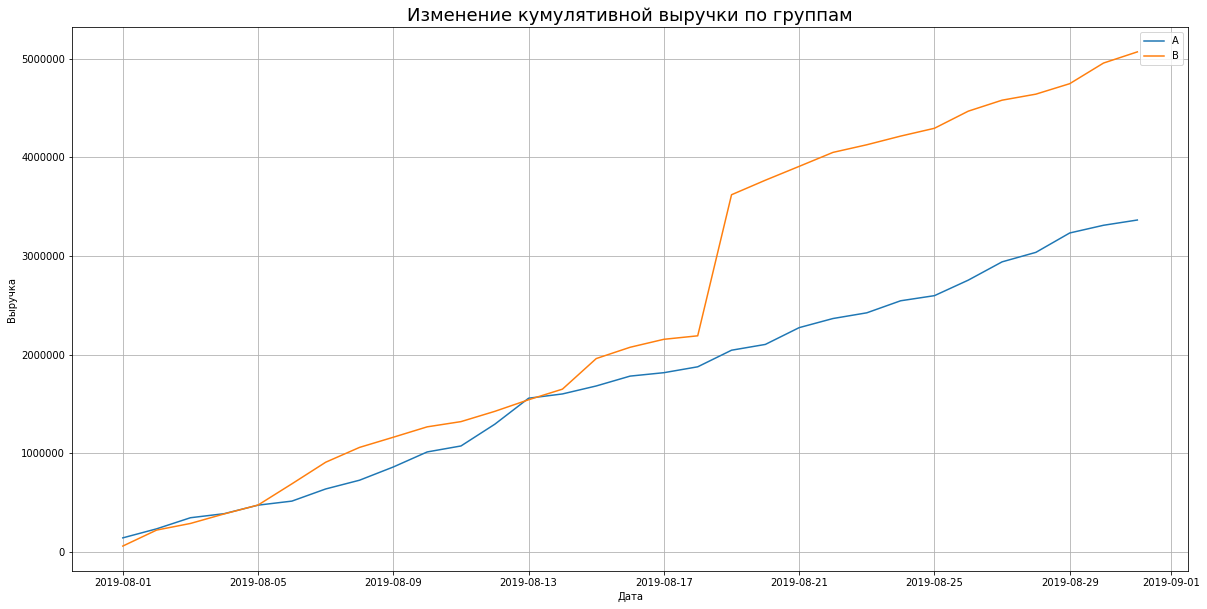

In [22]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(20,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Изменение кумулятивной выручки по группам', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend();

В первой половине месяца различия кумулятивной выручки между группами были небольшими. Но, начиная со второй половины месяца группа B резко вырывается вперёд и далее стабильно растёт. У группы A такой рост не наблюдается.
Можно сделать предположение, что в группу B попали аномальные пользователи. Поэтому в дальнейшем мы сделаем проверку на аномалии.

Кумулятивный средний чек.

Построим график кумулятивного среднего чека по дням и по группам.

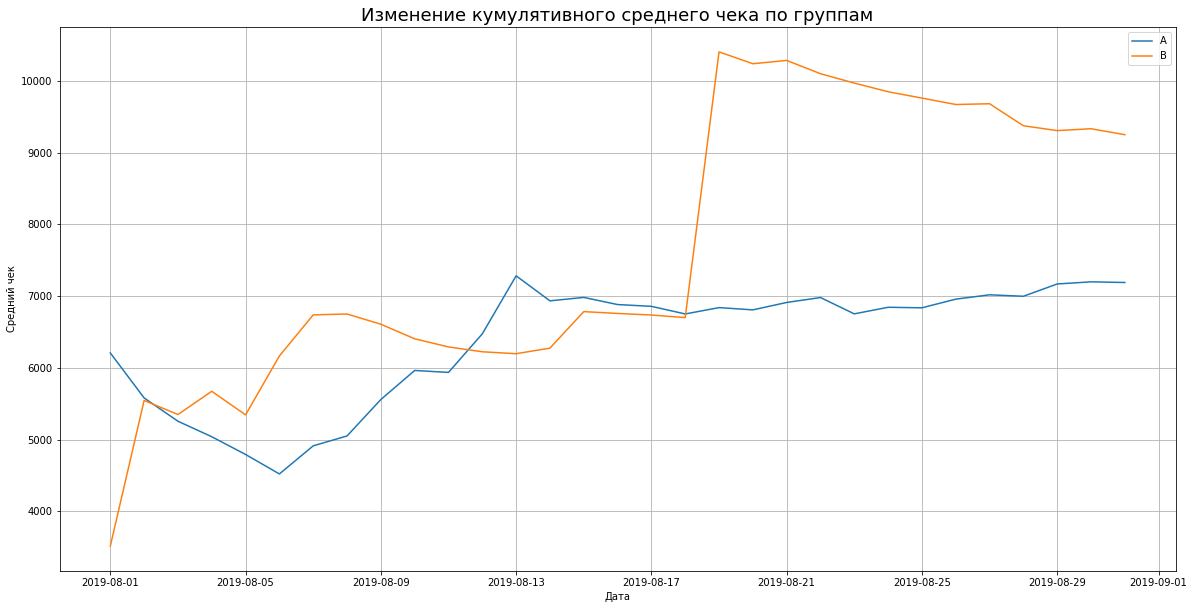

In [23]:
plt.figure(figsize=(20,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label = 'B')
plt.title('Изменение кумулятивного среднего чека по группам', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend();

Почти на протяжении всего периода кумулятивный средний чек группы B выше, чем средний чек группы A.
Также наблюдается резкий рост среднего чека группы B во второй половине месяца. Поэтому необходим дополнительный анализ выбросов.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

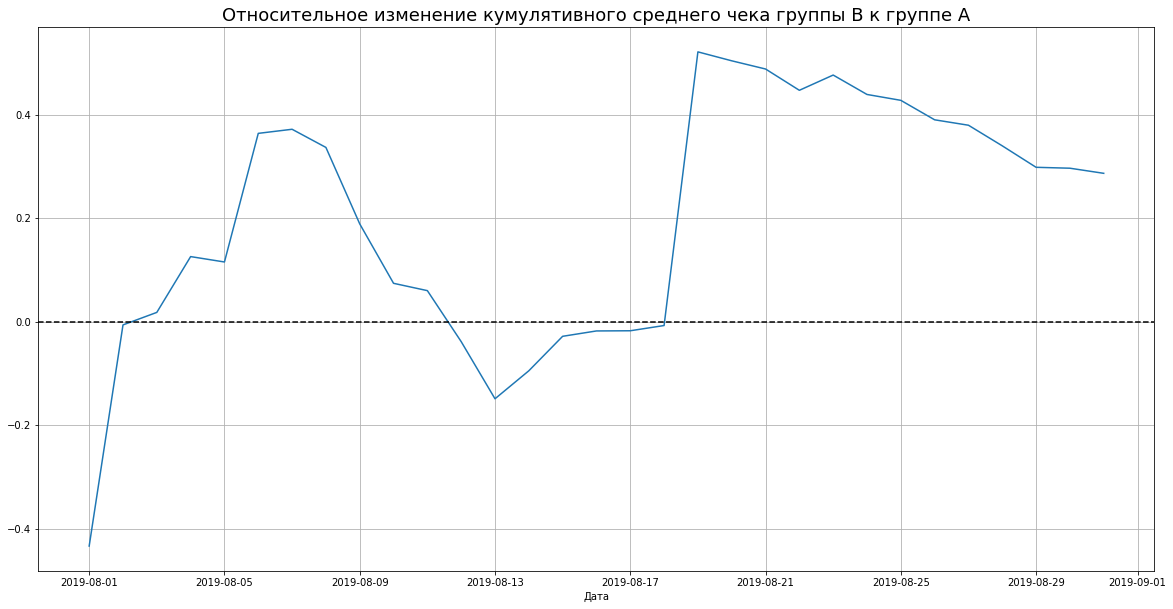

In [24]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20,10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) \
         / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', fontsize=18)
plt.xlabel('Дата')
plt.grid();

Результаты теста значительно и резко менялись несколько раз. Это может свидетельствовать о том, что в эти даты были совершены аномальные заказы. Данный график ещё раз показывает, необходимо исследовать данные на выбросы.

Кумулятивная конверсия.

Построим график кумулятивной конверсии по датам и по группам.

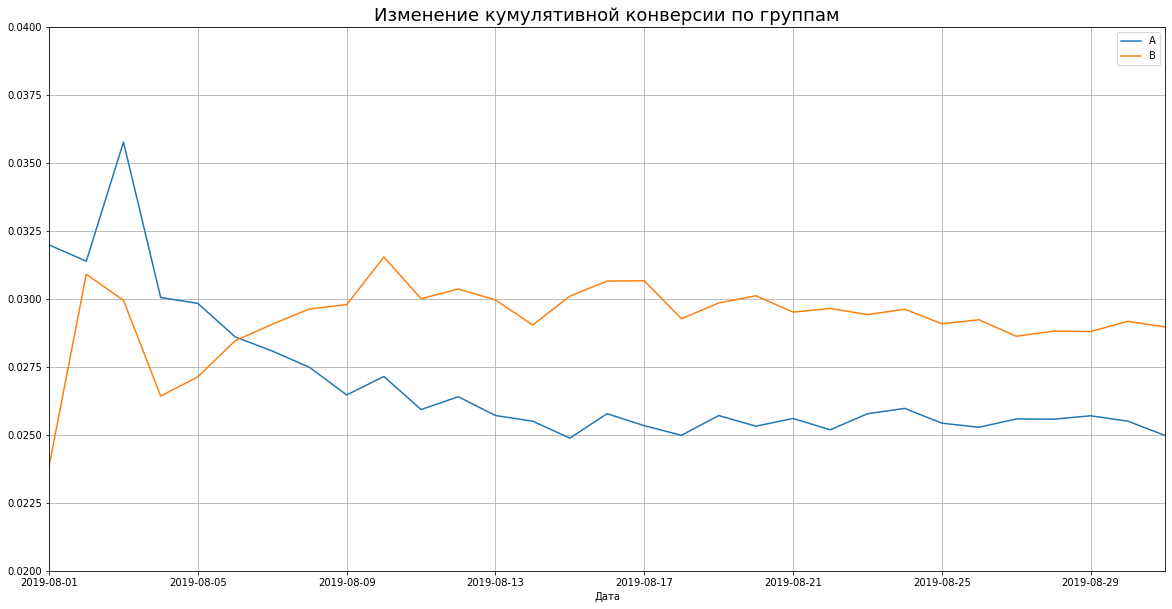

In [25]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(20,10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Изменение кумулятивной конверсии по группам', fontsize=18)
plt.xlabel('Дата')
plt.grid()
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.04]);


В начале теста наблюдаются колебания кумулятивной конверсии - то у группы A выше, то у группы B. Затем конверсия группы A снижается и выравнивается вокруг своего среднего значения, а конверсия группы B, наоборот, растёт и также выравнивается у своего среднего значения.
Группа B демонстрирует лучше конверсию, чем группа A, но это может быть следствием аномалий.

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

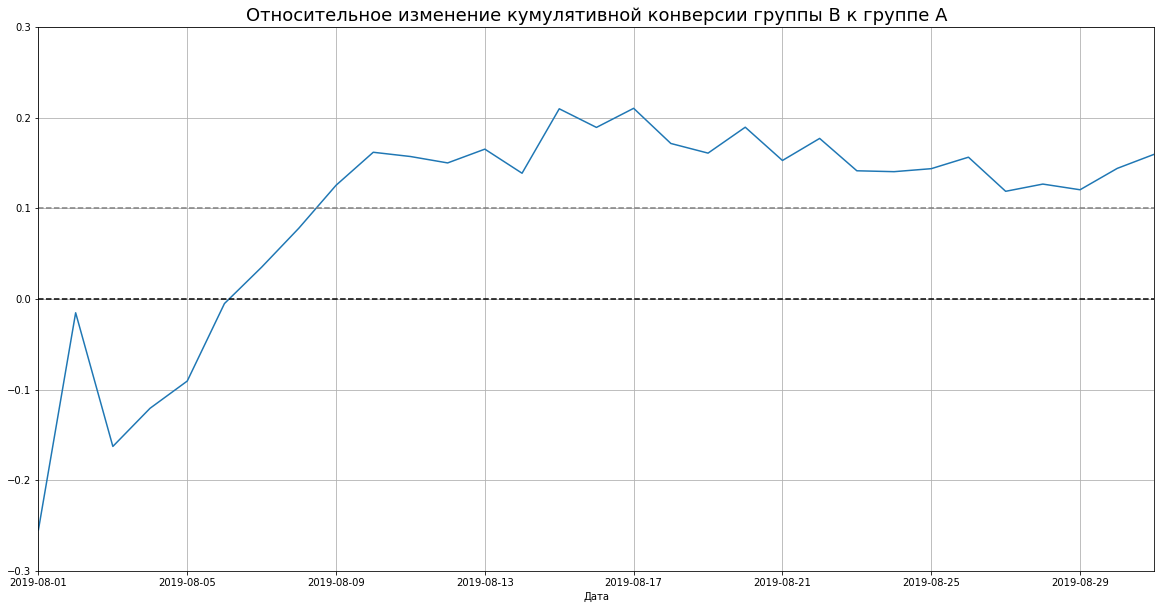

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']]\
                            .merge(cumulativeDataB[['date', 'conversion']],
                             left_on='date',
                             right_on='date',
                             how='left',
                             suffixes=['A', 'B'])
plt.figure(figsize=(20,10))
plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA']-1)
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A', fontsize=18)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.grid()
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.3]);

Группа B в начале периода демонстрирует конверсию хуже, чем у группы A, но  в дальнейшем она растёт, преодолевает уровень в 10% и даже 20%. При этом до конца периода этот показатель не опускается ниже 10%.
В следующих пунктах на необходимо проверить данные на аномалии и исключить их влияние.

### Анализ выбросов и всплесков: крайние значения данных

Посчитаем количество заказов по пользователям.

In [27]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Построим точечный график количества заказов по пользователям. 

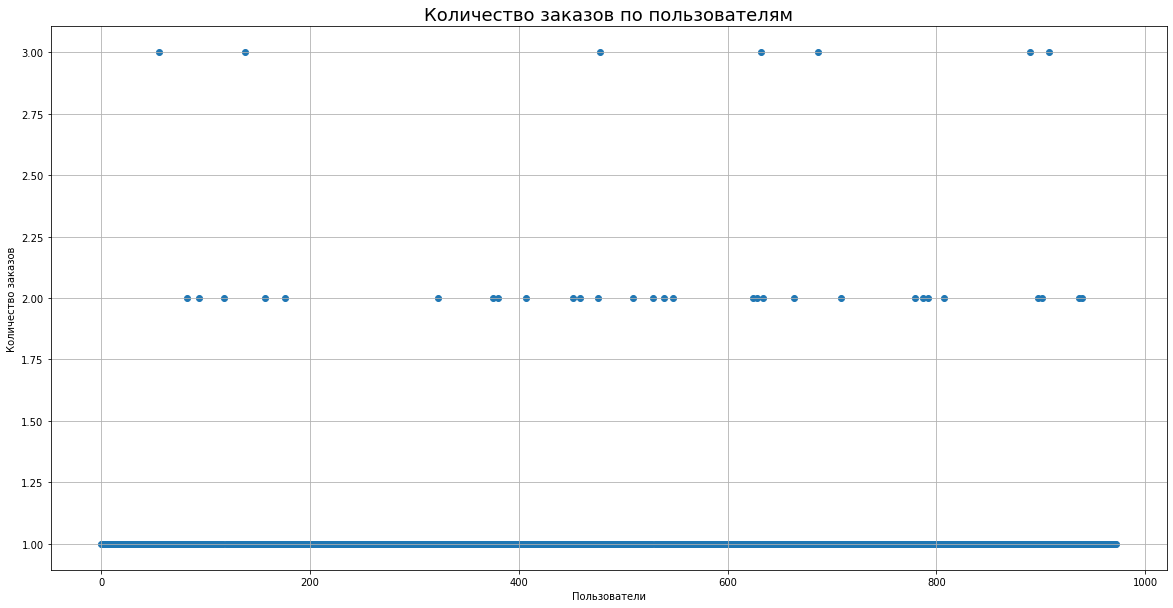

In [28]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(20,10))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям', fontsize=18)
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.grid();

Большинство пользователей совершает 1 заказ, остальные 2-3 заказа и эти значения похожи на выбросы.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [29]:
print('95-й перцентиль количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], 95))
print('99-й перцентиль количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], 99))

95-й перцентиль количества заказов на пользователя: 1.0
99-й перцентиль количества заказов на пользователя: 2.0


Доля пользователей, которые совершили более 1 заказа - 5%, а более 2 заказов - всего лишь 1%.

Построим точечный график стоимостей заказов.

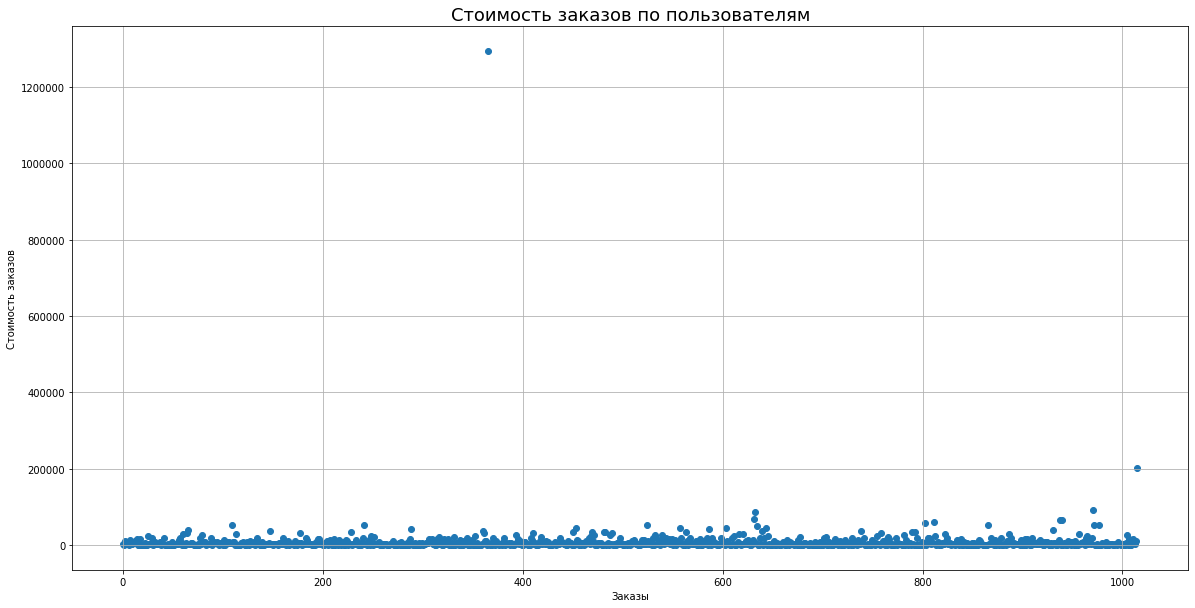

In [30]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(20,10))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям', fontsize=18)
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказов')
plt.grid();

Большинство заказов до 100 000, также мы видим, что один заказ более 1 200 000, он даёт искажение всей картины.
И из-за этого заказа не видно на графике распределение стоимости заказов.

Поэтому посчитаем 95-й и 99-й перцентили стоимости заказов.

In [31]:
print('95-й перцентиль стоимости заказов:', round(np.percentile(orders['revenue'], 95), 2))
print('99-й перцентиль стоимости заказов:', round(np.percentile(orders['revenue'], 99), 2))

95-й перцентиль стоимости заказов: 26785.0
99-й перцентиль стоимости заказов: 53904.0


Доля заказов, стоимость которых выше 26 785 - 5%, а выше 53 904 - всего лишь 1%.

С учётом выше сделанного анализа выбросов выберем границу для определения аномальных пользователей - более 1 заказа и  границу для определения аномальных заказов - более 26 785.

### Расчёт статистической значимости

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.
Сформулируем гипотезы:
- нулевая гипотеза - статистически значимых различий в конверсии нет;
- альтернативная гипотеза - статистически значимые различия в конверсии есть.

In [32]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [ordersByUsersA['orders'], pd.Series(0, index=np.arange(
        data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(0, index=np.arange(
        data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print('Относительное изменение конверсии группы B к группе A: {:.1%}'
      .format((data['ordersPerDateB'].sum()
                /data['visitorsPerDateB'].sum())
                /(data['ordersPerDateA'].sum()
                /data['visitorsPerDateA'].sum())-1))

P-value: 0.011
Относительное изменение конверсии группы B к группе A: 16.0%


Нулевую гипотезу отвергаем, так как P-value меньше 0.05. Соответственно, между группами есть статистически значимые различия в конверсии.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
Сформулируем гипотезы:
- нулевая гипотеза - статистически значимых различий в среднем чеке нет;
- альтернативная гипотеза - статистически значимые различия в среднем чеке есть.

In [34]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                   orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительное изменение среднего чека в группе B к группе A: {:.1%}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.829
Относительное изменение среднего чека в группе B к группе A: 28.7%


Нулевую гипотезу не можем отвергнуть, так как P-value больше 0.05. Соответственно, между группами нет статистически значимых различий в среднем чеке заказа. Нужно дополнительно проверить различие после того, как будут очищены данные от выбросов.

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.
Сформулируем гипотезы:
- нулевая гипотеза - статистически значимых различий в конверсии нет;
- альтернативная гипотеза - статистически значимые различия в конверсии есть.

Найдём аномальных пользователей.

In [35]:
usersWithManyOrders = pd.concat(
    [
       ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
       ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'], 
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers.head(5)

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitorId, dtype: int64

Отфильтруем данные, убрав аномальных пользователей.

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('Относительное изменение конверсии группы B к группе A: {:.1%}'
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.009
Относительное изменение конверсии группы B к группе A: 18.9%


По результатам теста нулевую гипотезу отвергаем, так как P-value меньше 0.05. Соответственно, между группами есть статистически значимые различия в конверсии после удаления выбросов.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сформулируем гипотезы:
- нулевая гипотеза - статистически значимых различий в среднем чеке нет;
- альтернативная гипотеза - статистически значимые различия в среднем чеке есть.

In [37]:
print('P-value: {0:.3f}'
      .format(stats.mannwhitneyu(
          orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
          orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
          alternative = 'two-sided')[1]))

print('Относительное изменение среднего чека в группе B к группе A: {:.1%}'
      .format(orders[np.logical_and(orders['group'] == 'B', 
                                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
              / orders[np.logical_and(orders['group'] == 'A', 
                                      np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

P-value: 0.762
Относительное изменение среднего чека в группе B к группе A: -2.2%


По результатам теста нулевую гипотезу не можем отвергнуть, так как P-value больше 0.05. Соответственно, между группами нет статистически значимых различий в среднем чеке после удаления выбросов.
Но относительное изменение среднего чека по "очищенным" данным показывает, что средний чек группы B на 2.2% снизился по отношению к группе A. Влияние аномалий было сильным, и мы это влияние убрали.

### Результаты A/B-теста

По результатам A/B-теста можно сделать следующие выводы:
- по "сырым" и "очищенным" данным есть статистически значимые различия в конверсии;
- относительный прирост конверсии группы B к группе A составляет 18.9% после удаления выбросов (было 16.0%);
- по "сырым" и "очищенным" данным нет статистически значимых различий в среднем чеке;
- относительное изменение среднего чека заказов группы B к группе A составляет -2.2% после удаления выбросов (было 28.7%).

На основе этих выводов можно принять решение остановить тест и зафиксировать победу групп B.

## Вывод

1) Приоритизация гипотез с помощью фреймворка ICE и RICE показала, что:
- наиболее перспективные гипотезы по ICE: 8, 0, 7;
- наиболее перспективные гипотезы по RICE: 7, 2, 0;
- после применения фреймворка RICE изменилась приоритизация и гипотеза 7 заняла первое место. Параметр Reach, который характеризует охват пользователей при применении данного гипотезы, самый высокий у гипотезы 7, что повлияло на изменение результатов приоритизации.

2) Анализ кумулятивных метрик показал, что:
- есть различия в кумулятивной выручке обеих групп - во второй половине месяца этот показатель у группы B резко вырос, а у группы A такой рост не наблюдается;
- кумулятивный средний чек группы B стабильно выше, чему у группы A, при этом резкий рост наблюдается также во второй половние месяца;
- кумулятивная конверсия групп в начале периода была с колебаниями, а потом стабилизировалась вокруг своих средних значений, при этом у группы B она выше, чем у группы A;
- относительное изменение конверсии группы B по отношению к группе A преодолевает прирост на 10%, с дальнейшим достижением 20%;
- все эти пункты свидетельствуют о том, что в группе B могут быть аномалии, которые нужно проверить и исключить их влияние.

3) Анализ выбросов и всплесков показал, что:
- 95% пользователей совершили 1 заказ, а 2 и более заказов - всего лишь 1%;
- 95% заказов имеют стоимость до 26 785, а выше 53 904 - всего лишь 1%;
- учитывая результаты анализа были выбраны границы для определения аномальных пользователей - более 1 заказа и границы для определения аномальных заказов - более 26 785.

4) Расчёт статистической значимости показал, что:
- исходные и отфильтрованные данные имеют статистически значимые различия в конверсии между группами;
- относительный прирост конверсии группы B к группе A составляет 18.9% после удаления выбросов (было 16.0%);
- исходные и отфильтрованные данные не имеют статистически значимых различий в среднем чеке заказов между группами;
- относительное изменение среднего чека заказов группы B к группе A составляет -2.2% после удаления выбросов (было 28.7%);
- было принято решение остановить тест, т.к. группа B показала прирост конверсии по отношению к группе A. Цель была достигнута.